# Logistic Regression Pipeline for MCF7 (GREG)

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the MCF7 cell-line in GREG.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

library(glmnet)
library(rms)
library(caret)
library(e1071)
library(ROSE)
library(DMwR)
library(ROCR)

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute


Loaded ROSE 0.0-3


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### <a id=link2>2. Loading Data </a>

In [2]:
mcf7gregStandard <- read.table("../data/MCF7forML.txt", header = TRUE) ## loading full data
mcf7greg <- mcf7gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(mcf7greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000,Non-Hub
6,0.05721561,0.09363865,0.03685132,0.05373381,0.05180643,0.09806973,0.0676687,0.03037976,0.132225,0.07040305,0.6368769,0.7405164,Non-Hub


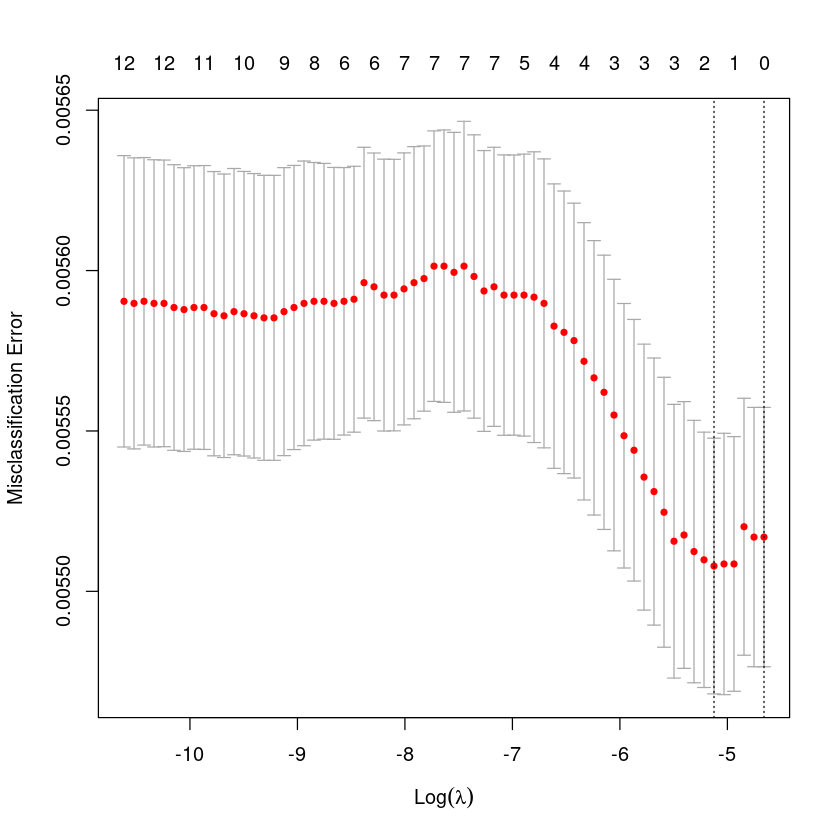

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(mcf7greg[,1:12]),
                         mcf7greg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [5]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 65 lambda values in all:
 0.009472285 0.008630793 0.007864057 0.007165436 0.006528878 0.005948871 0.005420389 0.004938857 0.004500103 0.004100326 0.003736064 0.003404163 0.003101746 0.002826196 0.002575124 0.002346357 0.002137913 0.001947987 0.001774933 0.001617253 0.001473581 0.001342672 0.001223393 0.00111471 0.001015682 0.0009254516 0.0008432371 0.0007683262 0.0007000702 0.0006378779 0.0005812106 0.0005295774 0.0004825312 0.0004396645 0.0004006059 0.0003650172 0.0003325901 0.0003030437 0.0002761221 0.0002515922 0.0002292414 0.0002088763 0.0001903203 0.0001734127 0.0001580072 0.0001439703 0.0001311804 0.0001195267 0.0001089083 9.923315e-05 9.041755e-05 8.23851e-05 7.506624e-05 6.839756e-05 6.232131e-05 5.678485e-05 5.174024e-05 4.714378e-05 4.295566e-05 3.91396e-05 3.566254e-05 3.249438e-05 2.960767e-05 2.697741e-05 2.458081e-05 
, out of which 2.458081e-05 is the minimum, while 0.009472285 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [7]:
set.seed(2)
modelfit <- glmnet(as.matrix(mcf7greg[,1:12]),
                   mcf7greg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)

# Listing non-zero coefficients
print(modelfit$beta[,1])

         CTCF         EP300      H3K27me3      H3K36me3       H3K4me1 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me2       H3K4me3        H3K9ac       H3K9me3         RAD21 
 0.000000e+00  0.000000e+00  0.000000e+00 -1.058848e-15  0.000000e+00 
      RNA.Seq       RNAPol2 
 0.000000e+00  0.000000e+00 


In [8]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)          CTCF         EP300      H3K27me3      H3K36me3 
 5.194404e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me1       H3K4me2       H3K4me3        H3K9ac       H3K9me3 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.058848e-15 
        RAD21       RNA.Seq       RNAPol2 
 0.000000e+00  0.000000e+00  0.000000e+00

   [[ suppressing 65 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



13 x 65 sparse Matrix of class "dgCMatrix"
                                                                        
(Intercept)  5.194404e+00  5.22803387  5.242114  5.25277442  5.263994759
CTCF         .             .           .         .           .          
EP300        .             .           .         .           .          
H3K27me3     .             .           .         .          -0.006191441
H3K36me3     .             .           .         .           .          
H3K4me1      .             .           .         .           .          
H3K4me2      .             .           .         .           .          
H3K4me3      .             .           .         .           .          
H3K9ac       .             .           .         .           .          
H3K9me3     -1.058848e-15 -0.04561906 -0.060643 -0.07072737 -0.075112850
RAD21        .             .           .         .           .          
RNA.Seq      .             .           .         .           .          
RNAPol2 

In [3]:
set.seed(5) # for reproducibility of results.
mcf7greg$Class <- as.numeric(as.factor(mcf7greg$Class))-1
part <- sample(2, nrow(mcf7greg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- mcf7greg[part==1,]
test <- mcf7greg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

mcf7model <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(mcf7model)

So, now we have 1085941 training rows and 464926 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4603   0.0953   0.0974   0.1037   8.4904  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.4212412  0.0144824 374.334  < 2e-16 ***
CTCF        -0.1231555  0.0104596 -11.774  < 2e-16 ***
EP300       -0.0006128  0.0065972  -0.093  0.92599    
H3K27me3    -0.0376144  0.0035553 -10.580  < 2e-16 ***
H3K36me3     0.0202301  0.0073217   2.763  0.00573 ** 
H3K4me1      0.0252831  0.0030960   8.166 3.18e-16 ***
H3K4me2     -0.0056000  0.0047127  -1.188  0.23472    
H3K4me3      0.0011819  0.0091394   0.129  0.89710    
H3K9ac      -0.0289041  0.0070872  -4.078 4.54e-05 ***
H3K9me3     -0.0802814  0.0051067 -15.721  < 2e-16 ***
RAD21        0.0471744  0.0076868   6.137 8.41e-10 ***
RNA.Seq      0.0061930  0.0036794   1.683  0.09234 .  
RNAPol2     -0.0343019  0.0022241 -15.423  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 

In [5]:
vif(mcf7model)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.651209  5.327598  3.000520 12.586785  2.216306  7.134589 18.402681  7.843155 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 4.674922  6.416018  1.017697  1.890691

Here, we can certainly get rid of <b>H3K4me2</b> and <b>H3K4me3</b>, as they have high *p* and vif values.

In [6]:
mcf7model1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
               data = train,
               family = "binomial")
summary(mcf7model1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4263   0.0953   0.0974   0.1036   8.4904  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.423398   0.014386 376.982  < 2e-16 ***
CTCF        -0.124736   0.010338 -12.065  < 2e-16 ***
EP300       -0.001401   0.006453  -0.217   0.8281    
H3K27me3    -0.037181   0.003537 -10.511  < 2e-16 ***
H3K36me3     0.019341   0.004492   4.306 1.66e-05 ***
H3K4me1      0.023841   0.002869   8.310  < 2e-16 ***
H3K9ac      -0.031208   0.006516  -4.789 1.67e-06 ***
H3K9me3     -0.081863   0.004955 -16.520  < 2e-16 ***
RAD21        0.047569   0.007674   6.199 5.70e-10 ***
RNA.Seq      0.006231   0.003674   1.696   0.0899 .  
RNAPol2     -0.034204   0.002211 -15.469  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

In [7]:
vif(mcf7model1)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1   H3K9ac  H3K9me3    RAD21 
5.536943 5.246144 2.979394 4.807476 1.897380 6.743977 4.398741 6.494531 
 RNA.Seq  RNAPol2 
1.018092 1.872461

Better !

In [8]:
yTrain <- predict(mcf7model1, train, type = "response")
head(yTrain)

1         2         4         5         7        10 
0.9956073 0.9956073 0.9956073 0.9956073 0.9954409 0.9975088

In [9]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,1
2,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,1
4,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,1
5,0,0,0,0,0,0,0,0,0,0,0.000000,0.0000000,1
7,0,0,0,0,0,0,0,0,0,0,2.557013,1.5576379,1
10,0,0,0,0,0,0,0,0,0,0,92.176049,0.1532103,1


In [10]:
prediction_probabilities_train <- ifelse(yTrain > 0.5, 1, 0) # Probabilities to Labels conversion
confusion_matrix_train <- table(Predicted = prediction_probabilities_train, Actual = train$Class)
print(confusion_matrix_train)

         Actual
Predicted       0       1
        0     108     181
        1    5914 1079738


In [11]:
misclassfication_error_train <- 1- sum(diag(confusion_matrix_train))/sum(confusion_matrix_train)
cat("The misclassification error in train data is",
    (round(misclassfication_error_train*100)), "percent")

The misclassification error in train data is 1 percent

In [12]:
yTest <- predict(mcf7model1, test, type = "response")
prediction_probabilities_test <- ifelse(yTest > 0.5, 1, 0)
confusion_matrix_test <- table(Predicted = prediction_probabilities_test, Actual = test$Class)
print(confusion_matrix_test)

         Actual
Predicted      0      1
        0     44     93
        1   2490 462299


In [13]:
misclassfication_error_test <- 1- sum(diag(confusion_matrix_test))/sum(confusion_matrix_test)
cat("The misclassification error in test data is",
    (round(misclassfication_error_test*100)), "percent")

The misclassification error in test data is 1 percent

In [14]:
overall_p <- 1 - pchisq(mcf7model1$null.deviance - mcf7model1$deviance,
                         mcf7model1$df.null - mcf7model1$df.residual,
                         lower.tail = FALSE)
cat("The statistical significance for the model is", overall_p, "\n")

The statistical significance for the model is 1 


In [15]:
cat("The confidence level for this model is",
    ((1-overall_p)*100), "percent")

The confidence level for this model is 0 percent

We can clearly observe that the model has **zero sensitivity** and **high specificity**. It means that the model is highly biased towards the non-hubs and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

In [16]:
sensitivity(confusion_matrix_train)

[1] 0.01793424

In [17]:
specificity(confusion_matrix_train)

[1] 0.9998324

In [18]:
sensitivity(confusion_matrix_test)

[1] 0.01736385

In [19]:
specificity(confusion_matrix_test)

[1] 0.9997989

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [20]:
table(mcf7greg$Class)


      0       1 
   8556 1542311 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [21]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1542311)$data

In [22]:
table(overTrain$Class)


      0       1 
 462392 1079919 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [23]:
mcf7modelOver <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
               data = overTrain,
               family = "binomial")
summary(mcf7modelOver)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.7631   0.6970   0.8248   8.4904  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  1.3285965  0.0027737  479.000  < 2e-16 ***
CTCF        -0.0978415  0.0027926  -35.036  < 2e-16 ***
EP300       -0.3087556  0.0027541 -112.107  < 2e-16 ***
H3K27me3    -0.0054268  0.0017550   -3.092  0.00199 ** 
H3K36me3     0.0188495  0.0010822   17.418  < 2e-16 ***
H3K4me1     -0.0666631  0.0011862  -56.199  < 2e-16 ***
H3K9ac       0.0311054  0.0019628   15.848  < 2e-16 ***
H3K9me3     -0.2099106  0.0020862 -100.616  < 2e-16 ***
RAD21        0.0789410  0.0019993   39.485  < 2e-16 ***
RNA.Seq      2.8642627  0.0020338 1408.297  < 2e-16 ***
RNAPol2     -0.1457491  0.0009537 -152.828  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 

In [24]:
yTestOver <- predict(mcf7modelOver, test, type = "response")
prediction_probabilities_testOver <- ifelse(yTestOver > 0.5, 1, 0)
confusion_matrix_testOver <- table(Predicted = prediction_probabilities_testOver, Actual = test$Class)
print(confusion_matrix_testOver)

         Actual
Predicted      0      1
        0    808  23956
        1   1726 438436


In [25]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testOver))*100, "%")

The sensitivity of the model is 31.88635 %

In [26]:
cat("The specificity of the model is", (specificity(confusion_matrix_testOver))*100, "%")

The specificity of the model is 94.81911 %

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [27]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 12000)$data
table(underTrain$Class)


   0    1 
6022 5978 

In [28]:
mcf7modelUnder <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(mcf7modelUnder)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.790  -1.153   0.000   1.015   5.893  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.746462   0.029418  25.374  < 2e-16 ***
CTCF        -0.078068   0.027353  -2.854  0.00432 ** 
EP300       -0.403771   0.032514 -12.418  < 2e-16 ***
H3K27me3    -0.035726   0.019011  -1.879  0.06022 .  
H3K36me3     0.054498   0.012538   4.347 1.38e-05 ***
H3K4me1      0.050270   0.014031   3.583  0.00034 ***
H3K9ac      -0.061150   0.024897  -2.456  0.01404 *  
H3K9me3     -0.210960   0.023621  -8.931  < 2e-16 ***
RAD21        0.010872   0.016314   0.666  0.50516    
RNA.Seq      0.013853   0.006243   2.219  0.02648 *  
RNAPol2     -0.056895   0.012482  -4.558 5.16e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

In [29]:
yTestUnder <- predict(mcf7modelUnder, test, type = "response")
prediction_probabilities_testUnder <- ifelse(yTestUnder > 0.5, 1, 0)
confusion_matrix_testUnder <- table(Predicted = prediction_probabilities_testUnder, Actual = test$Class)
print(confusion_matrix_testUnder)

         Actual
Predicted      0      1
        0   1338  96959
        1   1196 365433


In [30]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testUnder))*100, "%")

The sensitivity of the model is 52.80189 %

In [31]:
cat("The specificity of the model is", (specificity(confusion_matrix_testUnder))*100, "%")

The specificity of the model is 79.031 %

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

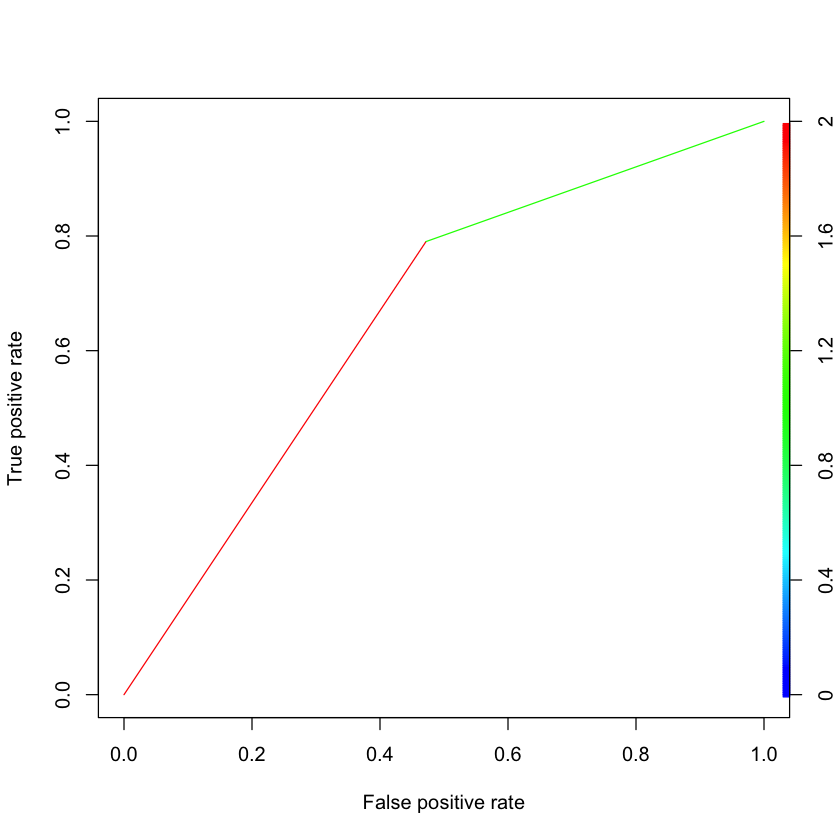

In [32]:
pred <- prediction(prediction_probabilities_testUnder, test$Class)
perf <- performance(pred, "tpr", "fpr")
plot(perf, colorize = TRUE)

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [4]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 18000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1089982 1083960 

In [35]:
mcf7modelSMOTE <- glm(formula = Class ~ .,
                    data = smoteData,
                    family = "binomial")
summary(mcf7modelSMOTE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteData)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.183  -1.150   0.000   1.009   8.490  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.771899   0.002219  347.825   <2e-16 ***
CTCF        -0.101347   0.002665  -38.028   <2e-16 ***
EP300       -0.424900   0.002518 -168.754   <2e-16 ***
H3K27me3    -0.049769   0.001545  -32.208   <2e-16 ***
H3K36me3     0.074438   0.001398   53.242   <2e-16 ***
H3K4me1      0.050620   0.001241   40.805   <2e-16 ***
H3K4me2      0.011042   0.001112    9.928   <2e-16 ***
H3K4me3     -0.011546   0.001328   -8.693   <2e-16 ***
H3K9ac      -0.079453   0.002056  -38.655   <2e-16 ***
H3K9me3     -0.220287   0.001867 -117.976   <2e-16 ***
RAD21        0.051428   0.002075   24.788   <2e-16 ***
RNA.Seq      0.011954   0.000557   21.461   <2e-16 ***
RNAPol2     -0.059548   0.001095  -54.358   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0

In [36]:
vif(mcf7modelSMOTE)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 3.397960  1.887846  2.313790 11.670977  2.151560  3.650094  8.484065  7.458183 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 2.668323  3.412534  1.032275  2.267890

All variables have high statistical significance. Following this observation, we shall omit the VIF scores for now, although we have high numbers for some variables.

In [37]:
yTestSMOTE <- predict(mcf7modelSMOTE, test, type = "response")
prediction_probabilities_testSMOTE <- ifelse(yTestSMOTE > 0.5, 1, 0)

The confusion matrix is
         Actual
Predicted      0      1
        0   1354  99725
        1   1180 362667
The sensitivity of the model is 53.43331 % 
The specificity of the model is 78.4328 % 
The area under curve is 0.6593305 


Warning message in if (class(model) %in% c("glm", "lm")) {:
“the condition has length > 1 and only the first element will be used”


The statistical significance for the model is 1 
The confidence level for the model is 0 %

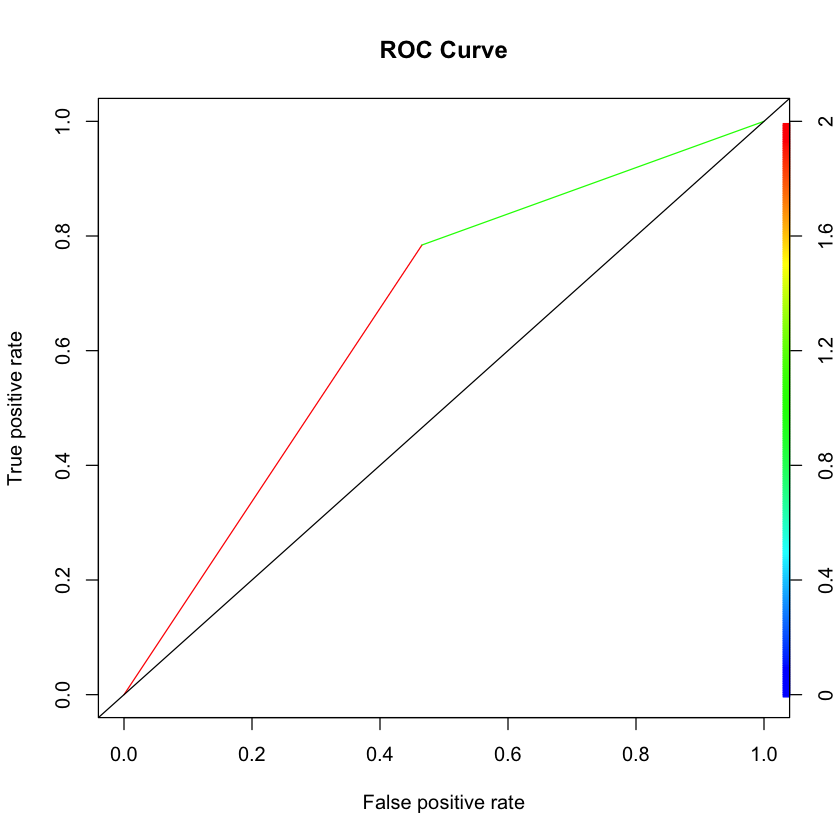

In [38]:
## Load a manually curated function 'modelPerformance()' to ascertain model performance
## Trace the function definition in the parent folder

source("modelPerformance.R")
modelPerformance(mcf7modelSMOTE, test, test$Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [39]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1542311)$data
table(bothTrain$Class)


     1      0 
770103 772208 

In [40]:
mcf7modelBoth <- glm(formula = Class ~ .,
               data = bothTrain,
               family = "binomial")
summary(mcf7modelBoth)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = bothTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-8.490  -1.007   0.000   1.151   1.900  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.768067   0.002618 -293.398   <2e-16 ***
CTCF         0.104223   0.002834   36.779   <2e-16 ***
EP300        0.403240   0.002903  138.901   <2e-16 ***
H3K27me3     0.057624   0.001799   32.033   <2e-16 ***
H3K36me3    -0.059237   0.001472  -40.244   <2e-16 ***
H3K4me1     -0.042459   0.001431  -29.679   <2e-16 ***
H3K4me2     -0.010753   0.001251   -8.594   <2e-16 ***
H3K4me3      0.004031   0.001446    2.788   0.0053 ** 
H3K9ac       0.067653   0.002213   30.577   <2e-16 ***
H3K9me3      0.214702   0.002168   99.011   <2e-16 ***
RAD21       -0.046560   0.002018  -23.066   <2e-16 ***
RNA.Seq     -0.012266   0.000654  -18.755   <2e-16 ***
RNAPol2      0.057880   0.001217   47.551   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0

The confusion matrix is
         Actual
Predicted      0      1
        0   1192 363781
        1   1342  98611
The sensitivity of the model is 47.04025 % 
The specificity of the model is 21.32628 % 
The area under curve is 0.3418326 


Warning message in if (class(model) %in% c("glm", "lm")) {:
“the condition has length > 1 and only the first element will be used”


The statistical significance for the model is 1 
The confidence level for the model is 0 %

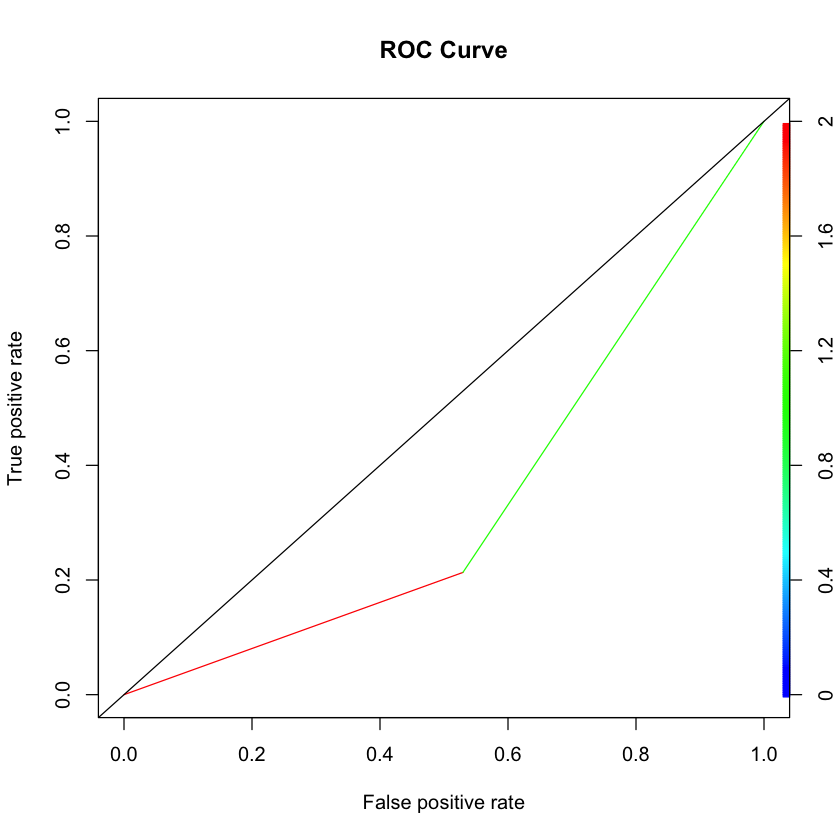

In [41]:
yTestBoth <- predict(mcf7modelBoth, test, type = "response")
prediction_probabilities_testBoth <- ifelse(yTestBoth > 0.5, 1, 0)
modelPerformance(mcf7modelBoth, test, test$Class)

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [5]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(mcf7greg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- mcf7greg[parts==1,]
testing <- mcf7greg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1240839 training rows and 310028 testing rows

In [43]:
mcf7paretoModel <- glm(formula = Class ~ ., data = training, family = "binomial")
summary(mcf7paretoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6770   0.0955   0.0975   0.1041   8.4904  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.4158153  0.0135281 400.338  < 2e-16 ***
CTCF        -0.1225363  0.0094531 -12.963  < 2e-16 ***
EP300       -0.0003951  0.0050589  -0.078 0.937749    
H3K27me3    -0.0409694  0.0032588 -12.572  < 2e-16 ***
H3K36me3     0.0090898  0.0061213   1.485 0.137561    
H3K4me1      0.0211940  0.0028611   7.408 1.29e-13 ***
H3K4me2     -0.0053800  0.0049164  -1.094 0.273830    
H3K4me3      0.0207663  0.0080570   2.577 0.009954 ** 
H3K9ac      -0.0241072  0.0067951  -3.548 0.000389 ***
H3K9me3     -0.0767593  0.0045200 -16.982  < 2e-16 ***
RAD21        0.0435751  0.0062911   6.926 4.31e-12 ***
RNA.Seq      0.0055815  0.0033313   1.675 0.093838 .  
RNAPol2     -0.0386374  0.0020650 -18.710  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.0

In [45]:
vif(mcf7paretoModel)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.342821  4.017142  2.937590  8.725425  2.138344  8.065220 13.687868  7.666776 
  H3K9me3     RAD21   RNA.Seq   RNAPol2 
 4.329607  5.289583  1.015485  2.032114

**H3K36me3**, **H3K4me2** could again be omitted for the reasons mentioned before. 

In [46]:
mcf7paretoModel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K4me1 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2,
                    data = training, family = "binomial")
summary(mcf7paretoModel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K4me1 + H3K4me3 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2, family = "binomial", 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6021   0.0954   0.0975   0.1040   8.4904  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.418373   0.013419 403.785  < 2e-16 ***
CTCF        -0.124291   0.009256 -13.428  < 2e-16 ***
EP300       -0.001825   0.004933  -0.370 0.711403    
H3K27me3    -0.040115   0.003232 -12.412  < 2e-16 ***
H3K4me1      0.018870   0.002566   7.355 1.91e-13 ***
H3K4me3      0.023929   0.004837   4.947 7.55e-07 ***
H3K9ac      -0.020961   0.005865  -3.574 0.000352 ***
H3K9me3     -0.079133   0.004361 -18.146  < 2e-16 ***
RAD21        0.043954   0.006267   7.013 2.33e-12 ***
RNA.Seq      0.005723   0.003344   1.711 0.087048 .  
RNAPol2     -0.038352   0.002038 -18.817  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

In [47]:
vif(mcf7paretoModel1)

CTCF    EP300 H3K27me3  H3K4me1  H3K4me3   H3K9ac  H3K9me3    RAD21 
5.184816 3.932726 2.897938 1.718792 5.197179 6.008499 4.021722 5.328431 
 RNA.Seq  RNAPol2 
1.015817 1.998551

The confusion matrix is
         Actual
Predicted      0      1
        0     28     44
        1   1618 308338
The sensitivity of the model is 1.701094 % 
The specificity of the model is 99.98573 % 
The area under curve is 0.5084341 


Warning message in if (class(model) %in% c("glm", "lm")) {:
“the condition has length > 1 and only the first element will be used”


The statistical significance for the model is 1 
The confidence level for the model is 0 %

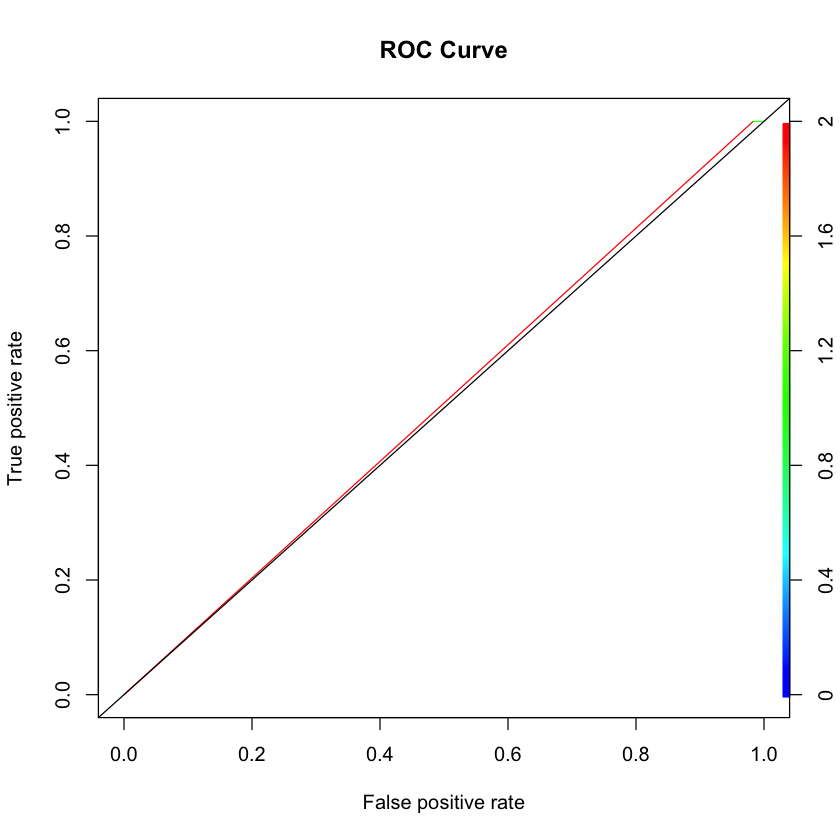

In [48]:
yTesting <- predict(mcf7paretoModel1, testing, type = "response")
prediction_probabilities_testing <- ifelse(yTesting > 0.5, 1, 0)
modelPerformance(mcf7paretoModel1, testing, testing$Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "1"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [6]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~., training, perc.over = 4000, k = 5, perc.under = 102)
table(smoteDatum$Class)


     0      1 
283310 281928 

In [7]:
mcf7paretoModelSmote <- glm(formula = Class ~ ., data = smoteDatum, family = "binomial")
summary(mcf7paretoModelSmote)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteDatum)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.818  -1.153   0.000   1.009   8.490  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.764912   0.004349 175.865  < 2e-16 ***
CTCF        -0.080856   0.005500 -14.701  < 2e-16 ***
EP300       -0.413529   0.004843 -85.382  < 2e-16 ***
H3K27me3    -0.049398   0.002993 -16.506  < 2e-16 ***
H3K36me3     0.056882   0.002414  23.567  < 2e-16 ***
H3K4me1      0.047808   0.002438  19.611  < 2e-16 ***
H3K4me2      0.014457   0.002274   6.359 2.03e-10 ***
H3K4me3      0.011368   0.002559   4.442 8.91e-06 ***
H3K9ac      -0.068355   0.003667 -18.642  < 2e-16 ***
H3K9me3     -0.220658   0.003608 -61.165  < 2e-16 ***
RAD21        0.017769   0.004332   4.102 4.10e-05 ***
RNA.Seq      0.014398   0.001098  13.111  < 2e-16 ***
RNAPol2     -0.068106   0.002175 -31.320  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 

In [8]:
vif(mcf7paretoModelSmote)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
3.793754 1.819679 2.260009 8.059915 2.174660 4.007287 6.900401 6.051996 
 H3K9me3    RAD21  RNA.Seq  RNAPol2 
2.592843 3.807066 1.043999 2.306421

The confusion matrix is
         Actual
Predicted      0      1
        0   1351  99843
        1   1183 362549
The accuracy of the model is 78.27052 % 
The misclassification error of the model is 21.72948 % 
The sensitivity of the model is 53.31492 % 
The specificity of the model is 78.40728 % 
The area under curve is 0.658611 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

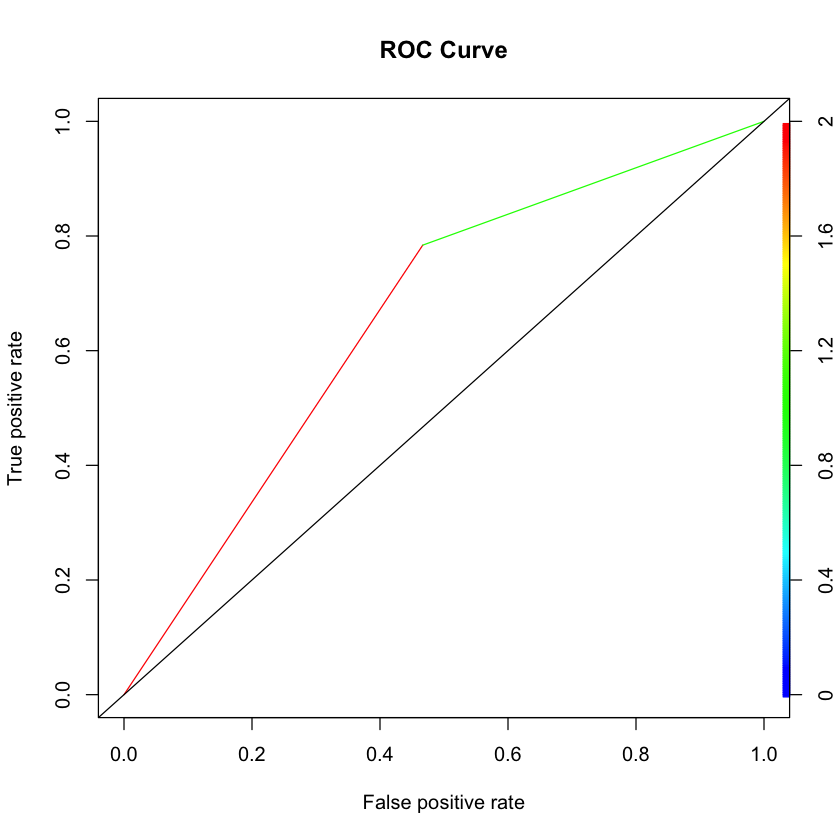

In [8]:
modelPerformance(mcf7paretoModelSmote, "lr", test, Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [9]:
mcf7gregModelPredictions <- predict(mcf7paretoModelSmote, mcf7greg, type = "response")
mcf7gregModelPredictionsProbs <- ifelse(mcf7gregModelPredictions > 0.5, 1, 0)

In [68]:
source("visualizeWithGviz.R")
visualizeWithGviz("MCF7forML.txt", "chr21", 1, 2, 3, 16, mcf7gregModelPredictionsProbs)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'Gviz'




The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpWZ6RwA/downloaded_packages


Old packages: 'knitr', 'labelled', 'multcomp', 'openxlsx', 'tinytex', 'withr'



The function **visualizeWithGviz** works too and outputs the plots and tables as external files written to current working directory.

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the A549 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> is the package we aim to deploy for visualization.

In [10]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
library(Gviz)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, 

<p align="justify"> Next, we recall the data from the MCF7 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! </p>

In [11]:
mcf7gregStandardRegionsClass <- mcf7gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [12]:
# Extracting chr21 data

mcf7gregChr21NonHub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
mcf7gregChr21Hub <- mcf7gregStandardRegionsClass[mcf7gregStandardRegionsClass$chr=="chr21" & mcf7gregStandardRegionsClass$Class=="Hub", ]

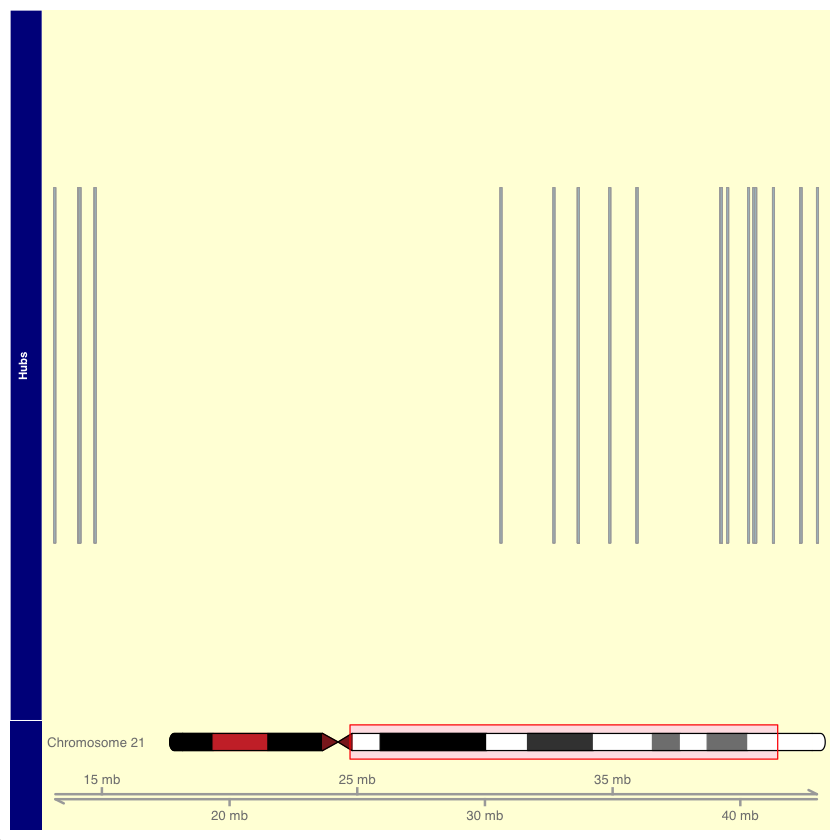

In [72]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

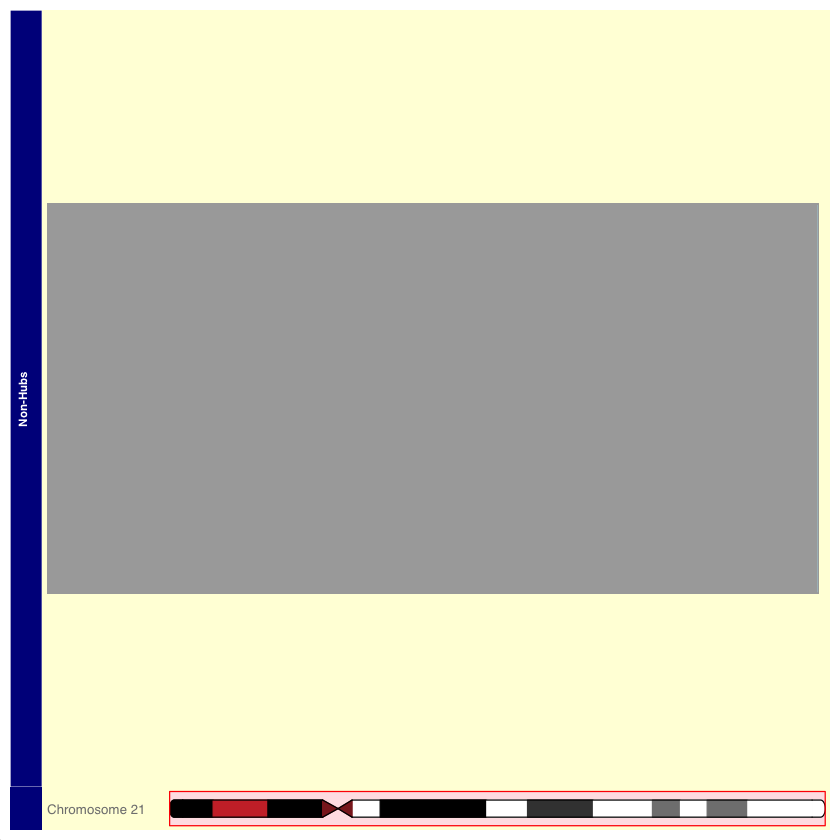

In [74]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = mcf7gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [13]:
mcf7gregPredicted <- cbind(mcf7gregStandardRegionsClass, mcf7gregModelPredictionsProbs)
names(mcf7gregPredicted)[names(mcf7gregPredicted)=="mcf7gregModelPredictionsProbs"] <- "Prediction"
mcf7gregPredicted$Prediction <- ifelse(mcf7gregPredicted$Prediction == 1, "Non-Hub", "Hub")            

Let us see if the classifier predictions match with the original results.

In [14]:
mcf7gregChr21PredicitedHub <- mcf7gregPredicted[mcf7gregPredicted$chr=="chr21" & mcf7gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

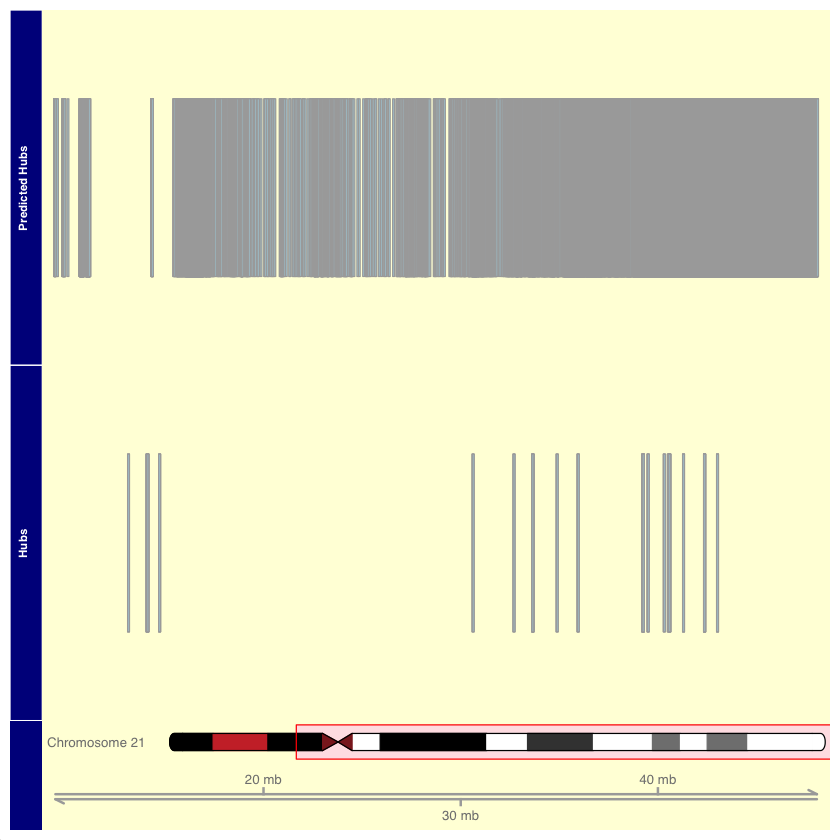

In [77]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = mcf7gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = mcf7gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [15]:
truePositives <- mcf7gregPredicted[mcf7gregPredicted$Class == mcf7gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [16]:
save(mcf7paretoModelSmote, file = "./optimalModels/mcf7modelLR")
write.table(truePositives, file = "./truePositives/mcf7LR.txt", quote = FALSE)

### <a id=link13>7. Session Information </a>

In [78]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui